This notebook reproduces all figures from "Parameter Transfer for Quantum Approximate Optimization of Weighted MaxCut"

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [2]:
from QAOAKit.utils import (
    get_full_weighted_qaoa_dataset_table, 
)  

df = get_full_weighted_qaoa_dataset_table()

In [3]:
df['r_opt'] = (df['C_opt'] - df['C_{true min}']) / (df['C_{true opt}'] - df['C_{true min}'])
df['r_trans'] = (df['C_{transfered unweighted to weighted}'] - df['C_{true min}']) / (df['C_{true opt}'] - df['C_{true min}'])

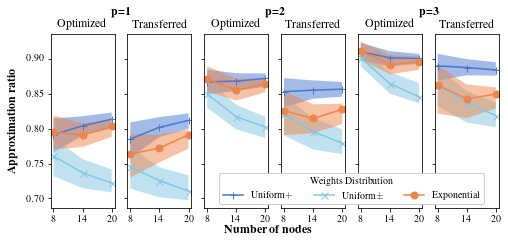

In [4]:
import seaborn as sns

# from https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(r'\textbf{'+title+'}\n')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')


grid = plt.GridSpec(1, 6)
f, ax = plt.subplots(1,6, sharey=True, figsize=((2.5*3.21283, 3.21283)))

ns = [8,14,20]

markers = {
    'uniform' : '+', 
    'neg_uniform': 'x', 
    'exp' : 'o', 
    'cauchy' : '.'
}

prettyprint = {
    'uniform' : r'Uniform$+$',
    'neg_uniform' : r'Uniform$\pm$',
    'exp' : 'Exponential',
    'cauchy' : 'Cauchy'
}

colors = {
    'uniform' : sns.color_palette("muted")[0], 
    'neg_uniform': sns.color_palette("muted")[9], 
    'exp' : sns.color_palette("muted")[1], 
    'cauchy' : sns.color_palette("muted")[5]
}

for idx1, p in enumerate([1,2,3]):
    for idx2, (metric, nsamples, ax_label) in enumerate([('r_opt', 0, 'Optimized'), ('r_trans',0, 'Transferred')]):
#         for distr in ['uniform', 'neg_uniform', 'exp', 'cauchy']:
        for distr in ['uniform', 'neg_uniform', 'exp']:
            mins = []
            twentyfifth = []
            medians = []
            seventyfifth = []
            maxs = []
            for n in ns:
                to_plot = df[
                    (df['p_max'] == p) & (df['n'] == n) & (df['Weight distribution'] == distr) & (df['nsamples'] == nsamples)
                ][metric]
                mins.append(to_plot.min())
                twentyfifth.append(to_plot.quantile(0.25))
                medians.append(to_plot.quantile(0.5))
                seventyfifth.append(to_plot.quantile(0.75))
                maxs.append(to_plot.max())
            ax[idx2 + 2*idx1].plot(ns, medians, label=prettyprint[distr] if idx1 + idx2 == 0 else '', marker=markers[distr], markersize=7, c=colors[distr])
            ax[idx2 + 2*idx1].fill_between(ns, twentyfifth, seventyfifth, facecolor=colors[distr], alpha=0.5)
        ax[idx2 + 2*idx1].set_title(ax_label)
        ax[idx2 + 2*idx1].set_xticks(ns)

create_subtitle(f, grid[0, 0:2], 'p=1')
create_subtitle(f, grid[0, 2:4], 'p=2')
create_subtitle(f, grid[0, 4:6], 'p=3')
f.supylabel(r'\textbf{Approximation ratio}',x = 0.05)
f.supxlabel(r'\textbf{Number of nodes}')
f.legend(ncol=3, loc='lower center',
        title='Weights Distribution',
        bbox_to_anchor=[0.6455, 0.12],
        framealpha=1)
plt.savefig('approximation_ratios_transfer.pdf')

In [5]:
df_BFGS = pd.read_json('../data/transfer_qaoa_weighted/bfgs.zip')
df_BFGS['G'] = df_BFGS.apply(
    lambda row: nx.node_link_graph(row['G_json']),
    axis=1,
)

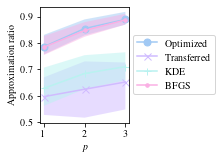

In [6]:
import seaborn as sns
from collections import defaultdict

f, ax = plt.subplots(figsize=(3.21283/1.1, 3.21283/1.5))

ns = [8,14,20]

markers = {
    ('r_opt', 0): 'o', 
    ('r_trans', 0) : 'x',
    ('r_trans', 10) : '+',
    'BFGS' :  '.'
}

colors = {
    ('r_opt', 0) : sns.color_palette("pastel")[0],
    ('r_trans', 0) : sns.color_palette("pastel")[4],
    ('r_trans', 10) :  sns.color_palette("pastel")[9],
    'BFGS' : sns.color_palette("pastel")[6]
}

distr = 'cauchy'
ps = [1,2,3]
twentyfifth = defaultdict(list)
medians = defaultdict(list)
seventyfifth = defaultdict(list)

for metric, nsamples in [('r_opt', 0), ('r_trans', 0), ('r_trans', 10)]:
    for p in ps:
        to_plot = df[
            (df['p_max'] == p) & (df['n'] == 14) & (df['Weight distribution'] == distr) & (df['nsamples'] == nsamples)
        ][metric]
        twentyfifth[(metric, nsamples)].append(to_plot.quantile(0.25))
        medians[(metric, nsamples)].append(to_plot.quantile(0.5))
        seventyfifth[(metric, nsamples)].append(to_plot.quantile(0.75))


for p in ps:
    to_plot = df_BFGS[
        (df_BFGS['p_max'] == p) & (df_BFGS['n'] == 14) & (df_BFGS['Weight distribution'] == distr)
    ]['r_BFGS']
    twentyfifth['BFGS'].append(to_plot.quantile(0.25))
    medians['BFGS'].append(to_plot.quantile(0.5))
    seventyfifth['BFGS'].append(to_plot.quantile(0.75))
        
        
ax.plot(ps, medians[('r_opt', 0)], marker=markers[('r_opt', 0)], markersize=7, c=colors[('r_opt', 0)], label=f"Optimized")
ax.plot(ps, medians[('r_trans', 0)], marker=markers[('r_trans', 0)], markersize=7, c=colors[('r_trans', 0)], label=f"Transferred")
ax.plot(ps, medians[('r_trans', 10)], marker=markers[('r_trans', 10)], markersize=7, c=colors[('r_trans', 10)], label=f"KDE")
ax.plot(ps, medians['BFGS'], marker=markers['BFGS'], markersize=7, c=colors['BFGS'], label=f"BFGS")

ax.fill_between(ps, twentyfifth[('r_opt', 0)], seventyfifth[('r_opt', 0)], facecolor=colors[('r_opt', 0)], alpha=0.5)
ax.fill_between(ps, twentyfifth[('r_trans', 0)], seventyfifth[('r_trans', 0)], facecolor=colors[('r_trans', 0)], alpha=0.5)
ax.fill_between(ps, twentyfifth[('r_trans', 10)], seventyfifth[('r_trans', 10)], facecolor=colors[('r_trans', 10)], alpha=0.5)
ax.fill_between(ps, twentyfifth['BFGS'], seventyfifth['BFGS'], facecolor=colors['BFGS'], alpha=0.5)

ax.set_xlabel('$p$')
ax.set_ylabel("Approximation ratio")
ax.set_xticks(ps)


# Shrink current axis's height by 20% on the top
box = ax.get_position()
ax.set_position([box.x0+0.05*box.width, box.y0 + box.height * 0.01,
                 box.width*0.55, box.height])
ax.legend(loc='upper center', 
        bbox_to_anchor=(1.5, 0.8))
# plt.tight_layout()
plt.savefig('Transfer_score_cauchy.pdf')

# Aggregate statistics

In [7]:
sall = pd.Series(dtype=float)

for idx, p in enumerate([1,2,3]):
    for distr in ['uniform', 'neg_uniform', 'exp']:
        for n in ns:
            sall = sall.append(df[
                (df['p_max'] == p) & (df['n'] == n) & (df['Weight distribution'] == distr) & (df['nsamples'] == 0)
            ]['transfer score unweighted to weighted'])
print(f"Median difference in approximation ratios: {sall.median() * 100:.1f} pp")

/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2925320088.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2925320088.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2925320088.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2925320088.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios: 2.0 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2925320088.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2925320088.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[


In [8]:
sall = pd.Series(dtype=float)

df_BFGS['transfer score unweighted to weighted'] = (df_BFGS['C_opt'] - df_BFGS['C_opt_BFGStransfer']) / (df_BFGS['C_{true opt}'] - df_BFGS['C_{true min}'])

for idx, p in enumerate([1,2,3]):
    for distr in ['cauchy']:
        for n in [14]:
            sall = sall.append(df_BFGS[
                (df_BFGS['p_max'] == p) & (df_BFGS['n'] == n) & (df_BFGS['Weight distribution'] == distr)
            ]['transfer score unweighted to weighted'])
print(f"Median difference in approximation ratios: {sall.median() * 100} pp")

Median difference in approximation ratios: 2.672790690544731e-10 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/476871615.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df_BFGS[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/476871615.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df_BFGS[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/476871615.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df_BFGS[


In [9]:
df_BFGS[df_BFGS['Weight distribution'] == 'cauchy']['transfer score unweighted to weighted'].describe()

count    9.000000e+02
mean     5.827734e-03
std      1.325228e-02
min     -7.143903e-02
25%      0.000000e+00
50%      2.672791e-12
75%      7.005998e-03
max      1.752491e-01
Name: transfer score unweighted to weighted, dtype: float64

In [10]:
sall = pd.Series(dtype=float)

for idx, p in enumerate([1,2,3]):
    for distr in ['uniform', 'neg_uniform', 'exp']:
        for n in ns:
            sall = sall.append(df[
                (df['p_max'] == p) & (df['n'] == n) & (df['Weight distribution'] == distr) & (df['nsamples'] == 10)
            ]['transfer score unweighted to weighted'])
print(f"Median difference in approximation ratios: {sall.median() * 100:.1f} pp")

/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2500251997.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2500251997.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2500251997.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2500251997.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios: 1.2 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2500251997.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[


In [11]:
df0 = pd.DataFrame()
df10 = pd.DataFrame()

for idx, p in enumerate([1,2,3]):
    for distr in ['uniform', 'neg_uniform', 'exp']:
        for n in ns:
            df0 = df0.append(df[
                (df['p_max'] == p) & (df['n'] == n) & (df['Weight distribution'] == distr) & (df['nsamples'] == 0)
            ])


for idx, p in enumerate([1,2,3]):
    for distr in ['uniform', 'neg_uniform', 'exp']:
        for n in ns:
            df10 = df10.append(df[
                (df['p_max'] == p) & (df['n'] == n) & (df['Weight distribution'] == distr) & (df['nsamples'] == 10)
            ])
            
sall = pd.merge(
    df0.reset_index().set_index(['graph_id', 'weight_id', 'p', 'Weight distribution', 'n']).add_suffix('_0'),
    df10.reset_index().set_index(['graph_id', 'weight_id', 'p', 'Weight distribution', 'n']).add_suffix('_10'), 
    how='left', 
    left_on = ['graph_id', 'weight_id', 'p', 'Weight distribution', 'n'], 
    right_on=['graph_id', 'weight_id', 'p', 'Weight distribution', 'n'])

assert len(sall) == len(df0)
assert len(sall) == len(df10)

ratio_median_is_best = len(sall[sall['transfer score unweighted to weighted_0'] > sall['transfer score unweighted to weighted_10']]) / len(sall)
print(f'KDE improves on just transferring the median in {ratio_median_is_best * 100:.1f} % of cases')

/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/403919292.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/403919292.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/403919292.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/403919292.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipy

/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/403919292.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df10 = df10.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/403919292.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df10 = df10.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/403919292.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df10 = df10.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/403919292.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df10 = df10.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw

KDE improves on just transferring the median in 89.5 % of cases


In [12]:
for idx, p in enumerate([1,2,3]):
    sall = pd.Series(dtype=float)
    for distr in ['uniform', 'neg_uniform', 'exp']:
        for n in ns:
            sall = sall.append(df[
                (df['p_max'] == p) & (df['n'] == n) & (df['Weight distribution'] == distr) & (df['nsamples'] == 0)
            ]['transfer score unweighted to weighted'])
    print(f"Median difference in approximation ratios for p={p}: {sall.median() * 100:.1f} pp")

/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/4254941812.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/4254941812.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/4254941812.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/4254941812.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for p=1: 1.2 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/4254941812.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/4254941812.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/4254941812.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/4254941812.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for p=2: 2.4 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/4254941812.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/4254941812.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/4254941812.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/4254941812.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for p=3: 3.0 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/4254941812.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[


In [13]:
for distr in ['uniform', 'neg_uniform', 'exp']:
    sall = pd.Series(dtype=float)
    for idx, p in enumerate([1,2,3]):
        for n in ns:
            sall = sall.append(df[
                (df['p_max'] == p) & (df['n'] == n) & (df['Weight distribution'] == distr) & (df['nsamples'] == 0)
            ]['transfer score unweighted to weighted'])
    print(f"Median difference in approximation ratios for distr={distr}: {sall.median() * 100:.1f} pp")

/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/3762012592.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/3762012592.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/3762012592.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/3762012592.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for distr=uniform: 1.0 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/3762012592.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/3762012592.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/3762012592.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/3762012592.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for distr=neg_uniform: 2.1 pp
Median difference in approximation ratios for distr=exp: 3.6 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/3762012592.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[


In [14]:
for distr in ['uniform', 'neg_uniform', 'exp']:
    for idx, p in enumerate([1,2,3]):
        sall = pd.Series(dtype=float)
        for n in ns:
            sall = sall.append(df[
                (df['p_max'] == p) & (df['n'] == n) & (df['Weight distribution'] == distr) & (df['nsamples'] == 0)
            ]['transfer score unweighted to weighted'])
        print(f"Median difference in approximation ratios for p={p}, distr={distr}: {sall.median() * 100:.1f} pp")

/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for p=1, distr=uniform: 0.5 pp
Median difference in approximation ratios for p=2, distr=uniform: 1.2 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[


Median difference in approximation ratios for p=3, distr=uniform: 1.6 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for p=1, distr=neg_uniform: 1.4 pp
Median difference in approximation ratios for p=2, distr=neg_uniform: 2.6 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[


Median difference in approximation ratios for p=3, distr=neg_uniform: 3.5 pp
Median difference in approximation ratios for p=1, distr=exp: 2.3 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for p=2, distr=exp: 4.1 pp
Median difference in approximation ratios for p=3, distr=exp: 4.5 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2027233491.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[


In [15]:
for idx, p in enumerate([1,2,3]):
    sall = pd.Series(dtype=float)
    for distr in ['uniform', 'neg_uniform', 'exp']:
        for n in ns:
            sall = sall.append(df[
                (df['p_max'] == p) & (df['n'] == n) & (df['Weight distribution'] == distr) & (df['nsamples'] == 10)
            ]['transfer score unweighted to weighted'])
    print(f"Median difference in approximation ratios for p={p}: {sall.median() * 100:.1f} pp")

/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1693804650.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1693804650.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1693804650.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1693804650.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for p=1: 0.7 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1693804650.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1693804650.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1693804650.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1693804650.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for p=2: 1.2 pp
Median difference in approximation ratios for p=3: 1.8 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1693804650.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[


In [16]:


for distr in ['uniform', 'neg_uniform', 'exp']:
    sall = pd.Series(dtype=float)
    for idx, p in enumerate([1,2,3]):
        for n in ns:
            sall = sall.append(df[
                (df['p_max'] == p) & (df['n'] == n) & (df['Weight distribution'] == distr) & (df['nsamples'] == 10)
            ]['transfer score unweighted to weighted'])
    print(f"Median difference in approximation ratios for distr={distr}: {sall.median() * 100:.1f} pp")

/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1918610132.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1918610132.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1918610132.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1918610132.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for distr=uniform: 0.6 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1918610132.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1918610132.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1918610132.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1918610132.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for distr=neg_uniform: 1.0 pp
Median difference in approximation ratios for distr=exp: 2.7 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/1918610132.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[


In [17]:


for distr in ['uniform', 'neg_uniform', 'exp']:
    for idx, p in enumerate([1,2,3]):
        sall = pd.Series(dtype=float)
        for n in ns:
            sall = sall.append(df[
                (df['p_max'] == p) & (df['n'] == n) & (df['Weight distribution'] == distr) & (df['nsamples'] == 10)
            ]['transfer score unweighted to weighted'])
        print(f"Median difference in approximation ratios for p={p}, distr={distr}: {sall.median() * 100:.1f} pp")

/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2797025387.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2797025387.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2797025387.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2797025387.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for p=1, distr=uniform: 0.3 pp
Median difference in approximation ratios for p=2, distr=uniform: 0.7 pp
Median difference in approximation ratios for p=3, distr=uniform: 1.1 pp
Median difference in approximation ratios for p=1, distr=neg_uniform: 0.6 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2797025387.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2797025387.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2797025387.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2797025387.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for p=2, distr=neg_uniform: 1.0 pp
Median difference in approximation ratios for p=3, distr=neg_uniform: 1.7 pp
Median difference in approximation ratios for p=1, distr=exp: 1.9 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2797025387.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2797025387.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2797025387.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2797025387.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[
/var/folders/gv/1pdmsc257d121pc1p5jx

Median difference in approximation ratios for p=2, distr=exp: 2.8 pp
Median difference in approximation ratios for p=3, distr=exp: 3.5 pp


/var/folders/gv/1pdmsc257d121pc1p5jxq1nw0000gn/T/ipykernel_97432/2797025387.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sall = sall.append(df[


In [18]:
df_tmp = df_BFGS[df_BFGS['Weight distribution'] == 'cauchy']
print('Cauchy')
print("Ratio of different beta:", sum(df_tmp['dist beta'] > 1e-3) / len(df_tmp))
print("Ratio of different gamma:", sum(df_tmp['dist gamma'] > 1e-3) / len(df_tmp))
print("Ratio of non-optimal:", sum(df_tmp['transfer score BFGS'] > 1e-7) / len(df_tmp))
print(f"Recover the same parameters in {100 - sum((df_tmp['dist gamma'] > 1e-4) & (df_tmp['dist beta'] > 1e-4)) / len(df_tmp) * 100:.2f}% cases")
print(f"Recover approximation ration up to machine precision in {100 - sum(df_tmp['transfer score BFGS'] > 1e-7) / len(df_tmp) * 100:.2f}% cases")

Cauchy
Ratio of different beta: 0.37444444444444447
Ratio of different gamma: 0.40444444444444444
Ratio of non-optimal: 0.36777777777777776
Recover the same parameters in 60.00% cases
Recover approximation ration up to machine precision in 63.22% cases


In [19]:
df_tmp = df_BFGS[df_BFGS['Weight distribution'] != 'cauchy']
print('All except Cauchy')
print("Ratio of different beta:", sum(df_tmp['dist beta'] > 1e-4) / len(df_tmp))
print("Ratio of different gamma:", sum(df_tmp['dist gamma'] > 1e-4) / len(df_tmp))
print("Ratio of different gamma:", sum((df_tmp['dist gamma'] > 1e-4) & (df_tmp['dist beta'] > 1e-4)) / len(df_tmp))
print("Ratio of non-optimal:", sum(df_tmp['transfer score BFGS'] > 1e-7) / len(df_tmp))
print(f"Recover the same parameters in {100 - sum((df_tmp['dist gamma'] > 1e-4) & (df_tmp['dist beta'] > 1e-4)) / len(df_tmp) * 100:.2f}% cases")
print(f"Recover approximation ration up to machine precision in {100 - sum(df_tmp['transfer score BFGS'] > 1e-7) / len(df_tmp) * 100:.2f}% cases")

All except Cauchy
Ratio of different beta: 0.031694815073205235
Ratio of different gamma: 0.0318595389668905
Ratio of different gamma: 0.031694815073205235
Ratio of non-optimal: 0.03153978082032499
Recover the same parameters in 96.83% cases
Recover approximation ration up to machine precision in 96.85% cases


In [20]:
for distr in ['uniform', 'neg_uniform', 'exp', 'cauchy']:
    for n in [8,14,20]:
        tmp = df[
               (df['p_max'] == 1) & (df['n'] == n) & (df['Weight distribution'] == distr) & (df['nsamples'] == 0)
        ]
        if len(tmp) > 0:
            print(distr, n)
            print(tmp['std(weight)'].describe())

uniform 8
count    11117.000000
mean         0.562254
std          0.115193
min          0.127780
25%          0.483806
50%          0.556884
75%          0.636477
max          1.109274
Name: std(weight), dtype: float64
uniform 14
count    300.000000
mean       0.569106
std        0.063096
min        0.371224
25%        0.528122
50%        0.569667
75%        0.609705
max        0.805926
Name: std(weight), dtype: float64
uniform 20
count    50.000000
mean      0.578997
std       0.048051
min       0.478903
25%       0.537926
50%       0.578953
75%       0.611545
max       0.711088
Name: std(weight), dtype: float64
neg_uniform 8
count    11117.000000
mean         1.108909
std          0.084216
min          0.199660
25%          1.069063
50%          1.114165
75%          1.158036
max          1.462834
Name: std(weight), dtype: float64
neg_uniform 14
count    300.000000
mean       1.136965
std        0.038285
min        0.965224
25%        1.116559
50%        1.136363
75%        1.160171

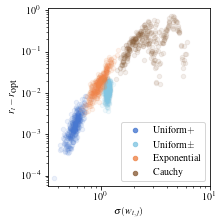

In [21]:
import seaborn as sns
import matplotlib as mpl
mpl.rc("savefig", dpi=500)

colors = {
    'uniform' : sns.color_palette("muted")[0], 
    'neg_uniform': sns.color_palette("muted")[9], 
    'exp' : sns.color_palette("muted")[1], 
    'cauchy' : sns.color_palette("muted")[5]
}

prettyprint = {
    'uniform' : r'Uniform$+$',
    'neg_uniform' : r'Uniform$\pm$',
    'exp' : 'Exponential',
    'cauchy' : 'Cauchy',
    'dist beta' : r'$\|\beta_{\mbox{opt}}-\beta_{\mbox{transf}}\|$',
    'dist gamma' : r'$\|\gamma_{\mbox{opt}}-\gamma_{\mbox{transf}}\|$',
}

f,ax = plt.subplots(figsize=(3.21283, 3.21283))

for distr in ['uniform', 'neg_uniform', 'exp', 'cauchy']:
    tmp = df[
           (df['p_max'] == 1) & (df['nsamples'] == 0) & (df['Weight distribution'] == distr) & (df['n'] == 14)
    ]
    tmp.plot.scatter(
        'std(weight)', 
        'transfer score unweighted to weighted', 
        color=colors[distr], 
        label=prettyprint[distr], 
        alpha=0.1, 
        ax=ax
    )
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$r_t-r_{\mbox{opt}}$')
plt.xlabel(r'$\sigma(w_{i,j})$')
ax.set_xticks([1.0, 10.0])
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(0.8)
plt.tight_layout()
plt.savefig('gap_vs_std_weight_n=14.png')

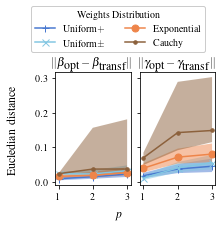

In [22]:
import seaborn as sns


import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

f, ax = plt.subplots(1,2, sharey=True, figsize=(3.21283, 3.21283))
plt.subplots_adjust(wspace=-0.1)

ps = [1,2,3]

markers = {
    'uniform' : '+', 
    'neg_uniform': 'x', 
    'exp' : 'o', 
    'cauchy' : '.'
}

prettyprint = {
    'uniform' : r'Uniform$+$',
    'neg_uniform' : r'Uniform$\pm$',
    'exp' : 'Exponential',
    'cauchy' : 'Cauchy',
    'dist beta' : r'$\|\beta_{\mbox{opt}}-\beta_{\mbox{transf}}\|$',
    'dist gamma' : r'$\|\gamma_{\mbox{opt}}-\gamma_{\mbox{transf}}\|$',
}

colors = {
    'uniform' : sns.color_palette("muted")[0], 
    'neg_uniform': sns.color_palette("muted")[9], 
    'exp' : sns.color_palette("muted")[1], 
    'cauchy' : sns.color_palette("muted")[5]
}

nsamples = 0

for idx, metric in enumerate(['dist beta', 'dist gamma']):
    for distr in ['uniform', 'neg_uniform', 'exp', 'cauchy']:
        mins = []
        twentyfifth = []
        medians = []
        seventyfifth = []
        maxs = []
        for p in ps:
            to_plot = df[
                (df['p_max'] == p) & (df['Weight distribution'] == distr) & (df['nsamples'] == nsamples)# & (df['same sign gamma'])
            ][metric]
            mins.append(to_plot.min())
            twentyfifth.append(to_plot.quantile(0.25))
            medians.append(to_plot.quantile(0.5))
            seventyfifth.append(to_plot.quantile(0.75))
            maxs.append(to_plot.max())
        ax[idx].plot(ps, medians, label=prettyprint[distr] if idx == 0 else '', marker=markers[distr], markersize=7, c=colors[distr])
        ax[idx].fill_between(ps, twentyfifth, seventyfifth, facecolor=colors[distr], alpha=0.5)
#         ax[idx].plot(ps,[np.linalg.norm(np.array([medians[0]] * p)) for p in ps], color='k', linestyle='dashed') # trend line
    ax[idx].set_title(prettyprint[metric])
    ax[idx].set_xticks(ps)
#     ax[idx].set_yticks([0,0.05,0.1,0.15])
    box = ax[idx].get_position()
    ax[idx].set_position([box.x0+box.width*0.25, box.y0 + box.height * 0.05,
                     box.width*0.8, box.height*0.65])

f.supylabel(r'Eucledian distance', y=0.4) #,x = 0.05)
f.supxlabel(r'$p$')
f.legend(ncol=2, loc='lower center',
        title='Weights Distribution',
        bbox_to_anchor=[0.5, 0.72],
        framealpha=1)
plt.savefig('distance_angles_transferred.pdf')

In [23]:
df['eweights'] = df.apply(
    lambda row: [a['weight'] for _,_,a in row['G'].edges(data=True)],
    axis=1
)

In [24]:
df['abs(eweights)'] = df.apply(
    lambda row: [abs(a['weight']) for _,_,a in row['G'].edges(data=True)],
    axis=1
)

In [25]:
df['max(abs(weight))'] = df.apply(
    lambda row: max(row['abs(eweights)']),
    axis=1
)

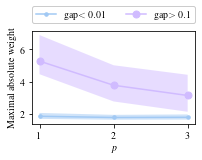

In [26]:
import seaborn as sns
from collections import defaultdict

f, ax = plt.subplots(figsize=(3.21283/1.1, 3.21283/1.5))

ns = [8,14,20]

markers = {
    'bad': 'o', 
    'good' :  '.'
}

colors = {
    'good' : sns.color_palette("pastel")[0],
    'bad' : sns.color_palette("pastel")[4],
}

ps = [1,2,3]
twentyfifth = defaultdict(list)
medians = defaultdict(list)
seventyfifth = defaultdict(list)

for p in ps:
    to_plot = df[
        (df['p_max'] == p) &  (df['nsamples'] == 0) & (df['transfer score unweighted to weighted'] < 0.01)
    ]['max(abs(weight))']
    
    twentyfifth['good'].append(to_plot.quantile(0.25))
    medians['good'].append(to_plot.quantile(0.5))
    seventyfifth['good'].append(to_plot.quantile(0.75))
    
    to_plot = df[
        (df['p_max'] == p) &  (df['nsamples'] == 0) & (df['transfer score unweighted to weighted'] > 0.1)
    ]['max(abs(weight))']

    twentyfifth['bad'].append(to_plot.quantile(0.25))
    medians['bad'].append(to_plot.quantile(0.5))
    seventyfifth['bad'].append(to_plot.quantile(0.75))
        
        
ax.plot(ps, medians['good'], marker=markers['good'], markersize=7, c=colors['good'], label=r"gap$< 0.01$")
ax.plot(ps, medians['bad'], marker=markers['bad'], markersize=7, c=colors['bad'], label=r"gap$> 0.1$")

ax.fill_between(ps, twentyfifth['good'], seventyfifth['good'], facecolor=colors['good'], alpha=0.5)
ax.fill_between(ps, twentyfifth['bad'], seventyfifth['bad'], facecolor=colors['bad'], alpha=0.5)

ax.set_xlabel('$p$')
ax.set_ylabel("Maximal absolute weight")
ax.set_xticks(ps)


# Shrink current axis's height by 20% on the top
box = ax.get_position()
ax.set_position([box.x0+0.05*box.width, box.y0 + box.height * 0.1,
                 box.width, box.height*0.8])
f.legend(ncol=2, loc='lower center',
        bbox_to_anchor=[0.55, 0.82],
        framealpha=1)
# plt.tight_layout()
plt.savefig('Max_weight.pdf')

# Enforce that betas are within [-0.5, 0.5]

In [27]:
import numpy as np
from tqdm import tqdm
tqdm.pandas()
tmp = df.progress_apply(
    lambda row: ((row['beta'] > np.full(row['p'], -0.5)) & (row['beta'] < np.full(row['p'], 0.5))).all(),
    axis=1,
)
assert(tmp.all())

100%|███████████████████████████████████████████████████████████████████████████████| 208206/208206 [00:08<00:00, 24723.20it/s]


In [28]:
tmp = df.progress_apply(
    lambda row: ((row['beta'] > np.full(row['p'], -0.5)) & (row['beta'] < np.full(row['p'], 0))).all(),
    axis=1,
)
tmp.all()

100%|███████████████████████████████████████████████████████████████████████████████| 208206/208206 [00:09<00:00, 22628.37it/s]


False

In [29]:
# ratio of betas that are not in [-0.5, 0], but are in [-0.5,0.5]
(len(tmp) - sum(tmp)) / len(tmp)

0.025455558437316887